# 1. Data Ingestion and basic quality checks

In [ ]:
!pip install --pre deepchem

clintox dataset has the following columns:
* smiles: chemical formula
* FDA_APPROVED: binary representation of FDA approval status
* CT_TOX: binary representation of toxicity report during clinical trials

In [ ]:
import pandas as pd
clintox_file = "/content/drive/MyDrive/Colab Notebooks/AppliedML/Clinical trials/clintox.csv"
clintox_task = ['CT_TOX']

clintox_data = pd.read_csv(clintox_file)
clintox_data.head(2)

,smiles,FDA_APPROVED,CT_TOX
0,*C(=O)[C@H](CCCCNC(=O)OCCOC)NC(=O)OCCOC,1,0
1,[C@@H]1([C@@H]([C@@H]([C@H]([C@@H]([C@@H]1Cl)C...,1,0


In [ ]:
from rdkit.Chem import PandasTools
#df = clintox_data
#PandasTools.AddMoleculeColumnToFrame(df, 'smiles', 'mol')

# Use Fingerprint of molecules
To train the model on a given drug, a fixed size of array would be required because different drugs would likely have different number of atoms. Therefore, fingerprint will be used to extract features from drugs. ECFP (Extended Connectivity Fingerprint) algorithm will be used as a base for Morgan Fingerprint to extract unique patterns as features. e.g: "carbon atom bonded to two hydrogens and two heavy atoms" would be a feature, and a particular element of the fingerprint is set to 1 for any molecule that contains that feature. For this project, 4096 features will be extracted from the chemical structure.

In [ ]:
len(clintox_data)

# number of bits for morgan fingerprints
morgan_bits = 4096
# number of radius for morgan fingerprints
#smaller radii captures more local info: capture specific functional groups
#larger: longer range connectivity patterns
morgan_radius = 2 # 2 atoms away

# Required RDKit modules
import rdkit as rd
from rdkit import DataStructs
from rdkit import Chem
from rdkit.Chem import AllChem

In [ ]:
data = [clintox_data]
data[0]['mol'] = [rd.Chem.MolFromSmiles(x) for x in data[0]['smiles']]


[00:58:31] Explicit valence for atom # 0 N, 5, is greater than permitted
[00:58:31] Can't kekulize mol.  Unkekulized atoms: 9
[00:58:31] Can't kekulize mol.  Unkekulized atoms: 4
[00:58:31] Can't kekulize mol.  Unkekulized atoms: 4


Initially, there were 1491 drugs

In [ ]:
print(  len(data[0])  )

1491


Some of the SMILES strings weren't able to be converted into the Morgan Fingerprint structure, therefore 1487 drugs will be used for building the model.

In [ ]:
#valid_indices = [j for j, mol in enumerate(data[0]['mol']) if mol is not None]  # some SMILES strings caused a failure, so remove them
valid_indices = []
invalid_indices = []

for j, mol in enumerate(data[0]['mol']):
    if mol is not None:
        valid_indices.append(j)
    else:
        invalid_indices.append(j)

print(len(valid_indices))
print(len(invalid_indices)) # The 4 molecules removed
failed_smiles = [data[0]['smiles'][j] for j in invalid_indices]
for idx, smi in zip(invalid_indices, failed_smiles):
    print(f"Failed SMILES at index {idx}: {smi}")

data[0]['morgan'] = [None] * len(data[0])
data[0]['bitInfo'] = [None] * len(data[0])
bi = [{} for _ in range(len(valid_indices))]

1487
4
Failed SMILES at index 7: [NH4][Pt]([NH4])(Cl)Cl
Failed SMILES at index 304: c1ccc(cc1)n2c(=O)c(c(=O)n2c3ccccc3)CCS(=O)c4ccccc4
Failed SMILES at index 1225: CCCCc1c(=O)n(n(c1=O)c2ccc(cc2)O)c3ccccc3
Failed SMILES at index 1226: CCCCc1c(=O)n(n(c1=O)c2ccccc2)c3ccccc3


The third and fourth molecule looks similar. Might be a valence issue in heterocyclic rings. The first molecule might have failed because RDKit may stuggle with organometallic compounds.

In [ ]:
for idx, j in enumerate(valid_indices):
    data[0].at[j, 'morgan'] = AllChem.GetMorganFingerprintAsBitVect(
        data[0].iloc[j]['mol'],
        morgan_radius,
        nBits=morgan_bits,
        bitInfo=bi[idx]
    )
    data[0].at[j, 'bitInfo'] = bi[idx]

[01:10:06] DEPRECATION WARNING: please use MorganGenerator
[01:10:06] DEPRECATION WARNING: please use MorganGenerator
[01:10:06] DEPRECATION WARNING: please use MorganGenerator
[01:10:06] DEPRECATION WARNING: please use MorganGenerator
[01:10:06] DEPRECATION WARNING: please use MorganGenerator
[01:10:06] DEPRECATION WARNING: please use MorganGenerator
[01:10:06] DEPRECATION WARNING: please use MorganGenerator
[01:10:06] DEPRECATION WARNING: please use MorganGenerator
[01:10:06] DEPRECATION WARNING: please use MorganGenerator
[01:10:06] DEPRECATION WARNING: please use MorganGenerator
[01:10:06] DEPRECATION WARNING: please use MorganGenerator
[01:10:06] DEPRECATION WARNING: please use MorganGenerator
[01:10:06] DEPRECATION WARNING: please use MorganGenerator
[01:10:06] DEPRECATION WARNING: please use MorganGenerator
[01:10:06] DEPRECATION WARNING: please use MorganGenerator
[01:10:06] DEPRECATION WARNING: please use MorganGenerator
[01:10:06] DEPRECATION WARNING: please use MorganGenerat

In [ ]:
print(data[0]['morgan'].head())

0    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...
1    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
2    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
3    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
4    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...
Name: morgan, dtype: object


In [ ]:
print(data[0].columns)

Index(['smiles', 'FDA_APPROVED', 'CT_TOX', 'mol', 'morgan', 'bitInfo'], dtype='object')


In [ ]:
valid_morgan_data = data[0].dropna(subset=['morgan']).reset_index(drop=True)


In [ ]:
print("FDA approved without toxicity concern report: " , len(valid_morgan_data[ ( valid_morgan_data['FDA_APPROVED'] == 1) & (valid_morgan_data['CT_TOX'] == 0)    ]))
print("FDA approved with toxicity concern report: ", len(valid_morgan_data[ ( valid_morgan_data['FDA_APPROVED'] == 1) & (valid_morgan_data['CT_TOX'] == 1)    ]))
print("FDA not approved without toxicity concern report: ", len(valid_morgan_data[ ( valid_morgan_data['FDA_APPROVED'] == 0) & (valid_morgan_data['CT_TOX'] == 0)    ]))
print("FDA not approved due to toxicity concern report: ", len(valid_morgan_data[ ( valid_morgan_data['FDA_APPROVED'] == 0) & (valid_morgan_data['CT_TOX'] == 1)    ]))

FDA approved without toxicity concern report:  1375
FDA approved with toxicity concern report:  18
FDA not approved without toxicity concern report:  0
FDA not approved due to toxicity concern report:  94


As shown above, the number of molecules with toxicity report is low. For training the model, I will use morgan FP as features, y value as CT_TOX = 0 or 1

In [ ]:
# Learning about data: finding insight from data
a = valid_morgan_data['morgan'].apply(lambda x: sum(x.ToList())) # number of unique substructures detected in each molecule
print(sorted(a, reverse=True)[:50])

[159, 142, 134, 128, 127, 125, 125, 125, 123, 120, 120, 120, 119, 119, 117, 117, 117, 115, 115, 113, 112, 111, 108, 107, 107, 106, 106, 106, 104, 103, 103, 103, 102, 101, 100, 100, 100, 97, 96, 96, 95, 94, 94, 93, 93, 93, 92, 91, 91, 91]


In [ ]:
print(len(a))
print(sum(a ==159))

1487
1


Amoung the 4096 features, the molecule with the highest number of unique chemical structure is 159.

In [ ]:
import numpy as np

b = np.array(valid_morgan_data['morgan'].apply(lambda x: x.ToList()).tolist())
column_sums = b.sum(axis=0) # how many molecules had that substructure
print(sorted(column_sums, reverse = True)[:50])
top_50_cols = sorted(column_sums, reverse=True)[:50]

[1283, 1188, 1091, 1089, 1012, 899, 820, 775, 751, 659, 598, 572, 566, 489, 482, 437, 430, 429, 381, 374, 360, 348, 327, 309, 303, 290, 268, 256, 254, 243, 231, 224, 219, 216, 211, 210, 196, 196, 194, 179, 179, 177, 177, 176, 175, 175, 171, 167, 162, 160]


Some of the features are common in various molecules (1283 out of 1487 drugs)

In [ ]:
column_sums.shape

(4096,)

In [ ]:
top_50_bits = np.argsort(column_sums)[::-1][:50]
top_50_bits # save the actual indices of the top column bits to visualize the substructures below

array([1380, 3921, 2698, 3105, 2128, 3798, 2855, 1917, 2974, 3067,  807,
       1088,  695, 2362, 2049, 2983, 3247,  875,  378, 2763, 3200, 3108,
       1325,  656, 2342, 3219, 1226, 2331, 3162, 3500,  389,  841, 3770,
       1683, 1274, 1257, 3786, 3959, 3802, 1162, 1028,  561, 3738, 1292,
       2162, 2270, 3777, 1928, 1480,  675])

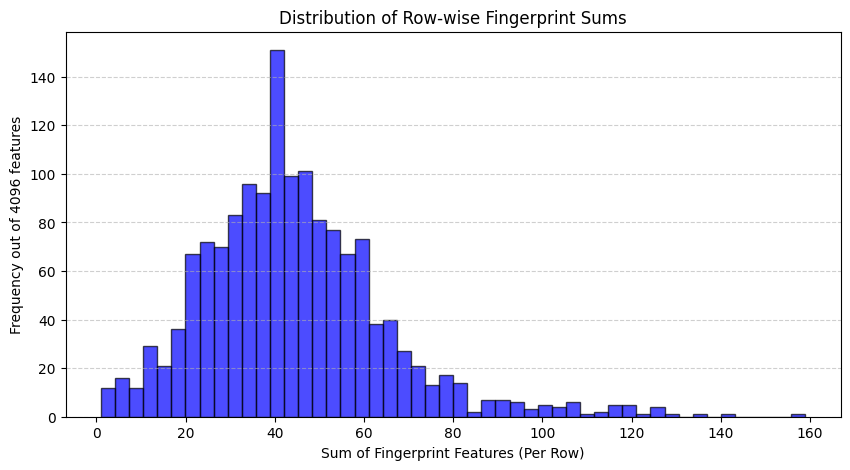

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.hist(a, bins=50, color='blue', alpha=0.7, edgecolor='black')
plt.xlabel("Sum of Fingerprint Features (Per Row)")
plt.ylabel("Frequency out of 4096 features")
plt.title("Distribution of Row-wise Fingerprint Sums")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

In [ ]:
min_x, max_x = min(a), max(a)

counts, bin_edges = np.histogram(a, bins=50)

max_y = counts.max()
print(f"X-axis range: min={min_x}, max={max_x}")
print(f"Maximum frequency (y-axis): {max_y}")

print(((a >= 39) & (a <= 42)).sum())
print( sum(a == 39), sum( a ==40), sum(a == 41), sum(a == 42))

X-axis range: min=1, max=159
Maximum frequency (y-axis): 151
151
44 37 38 32


X axis shows the unique substructures, which range from 1 to 159. The Y axis shows the number of molecules that have each specific number of features. Most molecules have between 30 and 50 features, with a noticeable spike around 40 features. Specifically, 151 molecules have between 39 and 42 features, and the highest count within this range is 44 molecules with exactly 39 features. Below, I will analyze if there is a common baseline structure within this range of features.

Interestingly, fewer molecules (long tail) have higher complex structures which may be because complex molecules may have more interaction sites which may increase uninteded interactions with the biological system.

 number of molecules with 39 substructures: 44


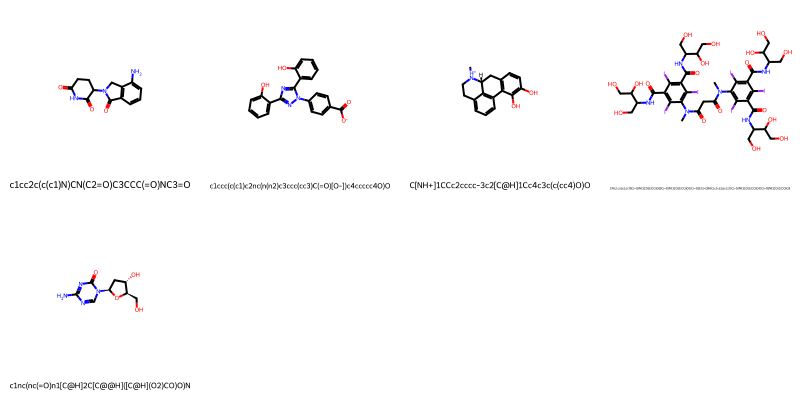

 number of molecules with 40 substructures: 37


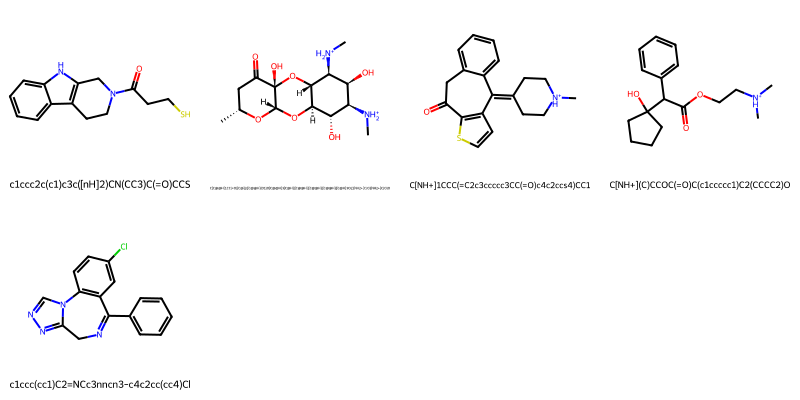

 number of molecules with 41 substructures: 38


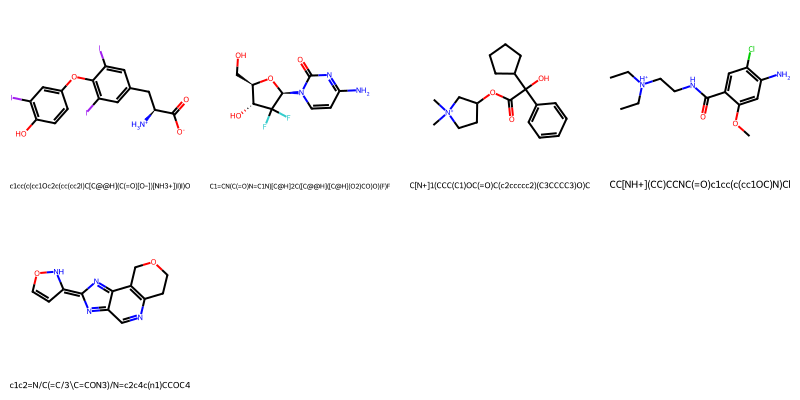

In [ ]:
from rdkit.Chem import Draw
from IPython.display import SVG, display

a_39 = (a == 39)
sa_39 = valid_morgan_data[a_39]
print(f" number of molecules with 39 substructures: {len(sa_39)}")
sa_39_sample = sa_39.sample(n=5, random_state=123)

example_mols = sa_39_sample['mol'].tolist()
smiles_list = sa_39_sample['smiles'].tolist()

svg = Draw.MolsToGridImage(example_mols, molsPerRow=4, subImgSize=(200, 200), legends=smiles_list, useSVG=True)
display(SVG(svg.data))

a_40 = (a == 40)
sa_40 = valid_morgan_data[a_40]
print(f" number of molecules with 40 substructures: {len(sa_40)}")
sa_40_sample = sa_40.sample(n=5, random_state=123)

example_mols = sa_40_sample['mol'].tolist()
smiles_list = sa_40_sample['smiles'].tolist()

svg = Draw.MolsToGridImage(example_mols, molsPerRow=4, subImgSize=(200, 200), legends=smiles_list, useSVG=True)
display(SVG(svg.data))

a_41 = (a == 41)
sa_41 = valid_morgan_data[a_41]
print(f" number of molecules with 41 substructures: {len(sa_41)}")
sa_41_sample = sa_41.sample(n=5, random_state=123)

example_mols = sa_41_sample['mol'].tolist()
smiles_list = sa_41_sample['smiles'].tolist()

svg = Draw.MolsToGridImage(example_mols, molsPerRow=4, subImgSize=(200, 200), legends=smiles_list, useSVG=True)
display(SVG(svg.data))


Based on the analysis above, we can see that the common structures within this range have multiple rings and functional groups. Many of them have amine, amide, hydroxyl, or ether groups, which may contribute to the complexity of the (around 40) features. The molecules with 39 substructures seem to have simpler side chains, and the ones with 40 substructures have more rigid multi-ring systems, with S and Cl found in some molecules. The molecules with 41 substructures seem more branched. Based on the randomly sampled molecules, it doesn't seem like there is a baseline structure.

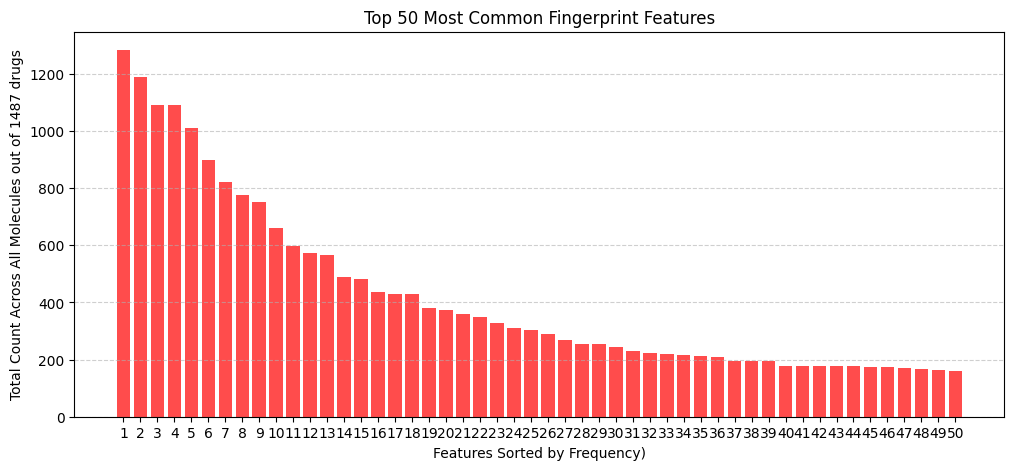

In [ ]:
plt.figure(figsize=(12, 5))
plt.bar(range(1, 51), top_50_cols, color='red', alpha=0.7)
plt.xlabel("Features Sorted by Frequency)")
plt.ylabel("Total Count Across All Molecules out of 1487 drugs")
plt.title("Top 50 Most Common Fingerprint Features")
plt.xticks(range(1, 51))
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

In [ ]:
top_50_bits

array([1380, 3921, 2698, 3105, 2128, 3798, 2855, 1917, 2974, 3067,  807,
       1088,  695, 2362, 2049, 2983, 3247,  875,  378, 2763, 3200, 3108,
       1325,  656, 2342, 3219, 1226, 2331, 3162, 3500,  389,  841, 3770,
       1683, 1274, 1257, 3786, 3959, 3802, 1162, 1028,  561, 3738, 1292,
       2162, 2270, 3777, 1928, 1480,  675])

Molecule 3 contains Bit Index 1380


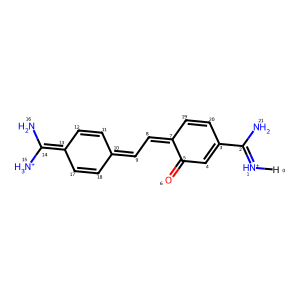

Molecule 4 contains Bit Index 1380


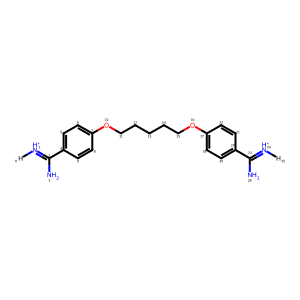

Molecule 12 contains Bit Index 1380


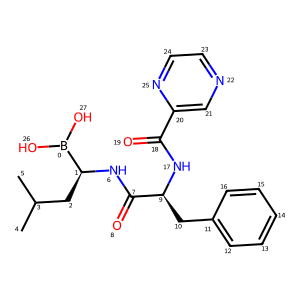

Molecule 13 contains Bit Index 1380


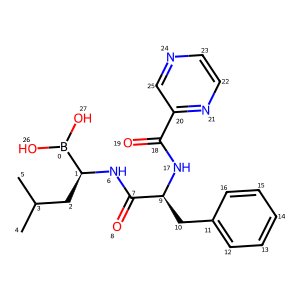

Molecule 14 contains Bit Index 1380


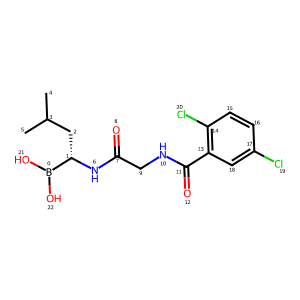

Molecule 16 contains Bit Index 1380


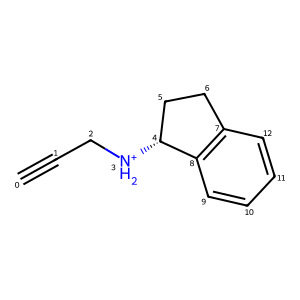

Molecule 17 contains Bit Index 1380


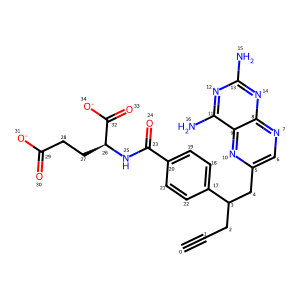

Molecule 20 contains Bit Index 1380


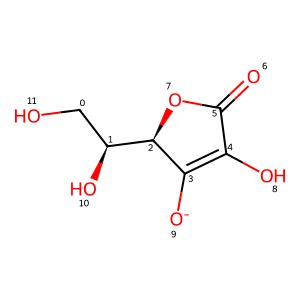

Molecule 26 contains Bit Index 1380


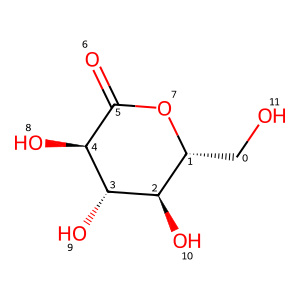

Molecule 67 contains Bit Index 1380


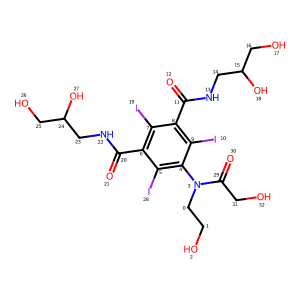

Molecule 75 contains Bit Index 1380


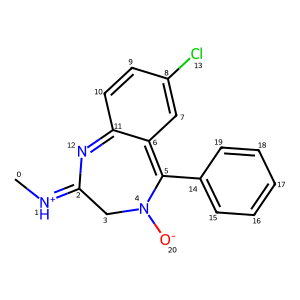

Molecule 76 contains Bit Index 1380


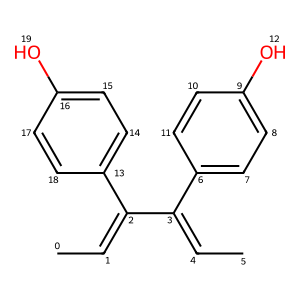

Molecule 77 contains Bit Index 1380


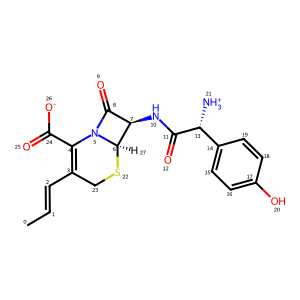

Molecule 78 contains Bit Index 1380


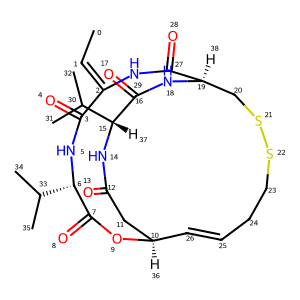

Molecule 79 contains Bit Index 1380


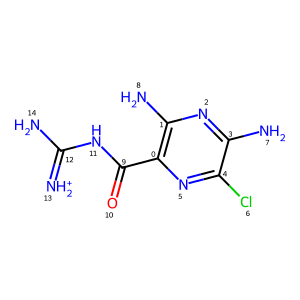

In [ ]:


def show_substructure(mol, bit_id, bit_info):
    if bit_id not in bit_info:
        return None
    atom_idx, radius = bit_info[bit_id][0]  # pick the first matching environment
    env = Chem.FindAtomEnvironmentOfRadiusN(mol, radius, atom_idx)
    atoms = set()
    for bidx in env:
        bond = mol.GetBondWithIdx(bidx)
        atoms.add(bond.GetBeginAtomIdx())
        atoms.add(bond.GetEndAtomIdx())
    d = Draw.MolDraw2DSVG(300, 300)
    d.drawOptions().addAtomIndices = True
    d.DrawMolecule(mol, highlightAtoms=list(atoms))
    d.FinishDrawing()
    return d.GetDrawingText()

bit_id = 1380
shown = 0

for i in range(len(valid_morgan_data)):
    mol = valid_morgan_data.iloc[i]['mol']
    bit_info = valid_morgan_data.iloc[i]['bitInfo']
    if bit_id in bit_info:
        print(f"Molecule {i} contains Bit Index {bit_id}")
        svg = show_substructure(mol, bit_id, bit_info)
        if svg:
            display(SVG(svg))
            shown += 1
            if shown >= 15:
                break

Based on the image above, it seems like the most common substruture might have to do with the aromatic ring form or the carbonyl group adjacent to the rings or amines. Some other patterns that can be spotted are amine containing structures or substituted heterocycles (Nitrogen containing ring)

Now, I will try to analyze whether the rows with higher feature sums have higher percentage of Non toxic features and FDA approval rates.

In [ ]:
feature_df = pd.DataFrame({
    "feature_sum": valid_morgan_data['morgan'].apply(lambda x: sum(x.ToList())),
    "CT_TOX": valid_morgan_data["CT_TOX"],
    "FDA_approved" : valid_morgan_data["FDA_APPROVED"]
})

In [ ]:
print(feature_df)

      feature_sum  CT_TOX  FDA_approved
0              36       0             1
1               5       0             1
2              14       0             1
3              39       0             1
4              28       0             1
...           ...     ...           ...
1482            6       0             1
1483            4       0             1
1484            3       0             1
1485            6       0             1
1486            4       0             1

[1487 rows x 3 columns]


<ipython-input-38-d97ba61e9c97>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x="CT_TOX", y="feature_sum", data=feature_df, ax=axes[0], palette="Blues")
<ipython-input-38-d97ba61e9c97>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x="FDA_approved", y="feature_sum", data=feature_df, ax=axes[1], palette="Greens")


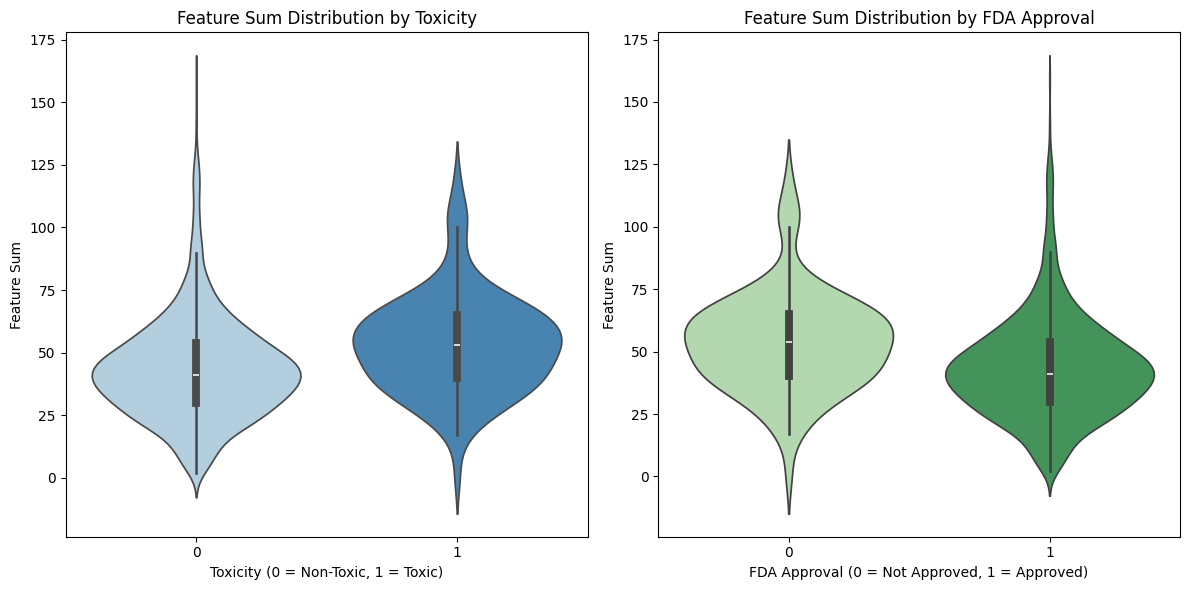

In [ ]:
import seaborn as sns
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

sns.violinplot(x="CT_TOX", y="feature_sum", data=feature_df, ax=axes[0], palette="Blues")
axes[0].set_title("Feature Sum Distribution by Toxicity")
axes[0].set_xlabel("Toxicity (0 = Non-Toxic, 1 = Toxic)")
axes[0].set_ylabel("Feature Sum")

sns.violinplot(x="FDA_approved", y="feature_sum", data=feature_df, ax=axes[1], palette="Greens")
axes[1].set_title("Feature Sum Distribution by FDA Approval")
axes[1].set_xlabel("FDA Approval (0 = Not Approved, 1 = Approved)")
axes[1].set_ylabel("Feature Sum")

plt.tight_layout()
plt.show()

Interestingly, molecules that showed toxicity had slightly higher feature sums on average, and molecules that were FDA approved had slightly lower feature sums.